# Natural Language Processing

### Basic Implementation

**Dataset**: SMS Spam Collection https://archive.ics.uci.edu/ml/datasets/sms+spam+collection



In [127]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from nltk.corpus import stopwords

sns.set_style('white')

%matplotlib inline

In [5]:
# Download the 'stopwords' package
# nltk.download_shell()

In [7]:
filepath = 'data/smsspamcollection/SMSSpamCollection'

# Read in the lines and store each in a list
messages = [line.rstrip() for line in open(filepath, encoding='UTF8')]

In [14]:
# Check the first item in messages
messages[0]

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [18]:
# Each line appears to be a tab-separated value.
# Verify this by reading the first 2 lines

for message_num, message in enumerate(messages[:2]):
    print(message_num, message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...




In [20]:
# Format the data into a pandas dataframe

messages = pd.read_csv(filepath, sep='\t', names=['label', 'message'])

# Check the first 5 rows
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Quick Exploratory Analysis

In [21]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [22]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label      5572 non-null object
message    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [27]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [33]:
# Create a length column to store length of message
messages['length'] = messages['message'].apply(len)
messages.head(2)

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29


## Visualization

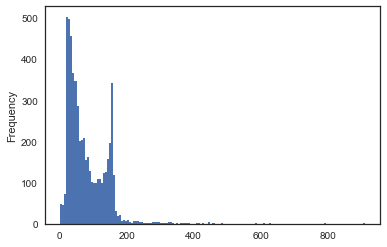

In [53]:
messages['length'].plot.hist(bins=150)

In [46]:
# Find and print the longest message
messages[messages['length'] == messages['length'].max()]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000013C129220B8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000013C12907A58>], dtype=object)

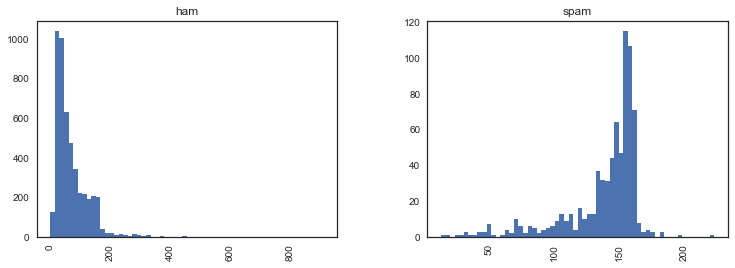

In [54]:
messages.hist(column='length', by='label', bins=60, figsize=(12,4))


#### It appears that the spam messages have a tendency to be longer.

## Text Pre-processing

Currently, the data is all in text format (corpus). In order to apply classification algorithms on the data, there must be a numerical featrue vector. Using the **bag of words** approach, we will now convert the corpus into a vector format, where each unique word in a message is represented by either 0 or 1.

In [124]:
# Define a function that pre-proceses a given string and returns a list of meaningful words
def text_process(message):
    """
    1. remove punctuation
    2. remove stop words
    3. return list of clean text words
    """
    
    nopunc = [char for char in message if char not in string.punctuation]
    nopunc = ''.join(nopunc).split()
    
    eng_stopwords = stopwords.words('english')
    return [word for word in nopunc if word.lower() not in eng_stopwords]

In [125]:
# Take a look at the original data again.
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [126]:
# Tokenize the messages.
messages['message'].head().apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

The list of tokens must now be converted to a vector in 3 steps:

1. Count how many times does a word occur in each message (term frequency)
2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

In [128]:
# create bag of words
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

# count total number of vocabs in bag of words
print(len(bow_transformer.vocabulary_))

11425


In [129]:
# Take the third SMS message for example.
message4 = messages['message'][3]
print(message4)

# Check the vector representation of the bag of words for this message
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

U dun say so early hor... U c already then say...
  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


There are 7 unique words (not including stopwords), of which two appear twice, and the rest appear only once. 

Now, transform the entire DataFrame of messages and check out the shape of the entire bag of words (a large sparse matrix).

In [132]:
messages_bow = bow_transformer.transform(messages['message'])
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('Sparsity: {}'.format(round(sparsity)))

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548
Sparsity: 0


## TF-IDF

In [133]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.538562626293
  (0, 7186)	0.438936565338
  (0, 6222)	0.318721689295
  (0, 6204)	0.299537997237
  (0, 5261)	0.297299574059
  (0, 4629)	0.266198019061
  (0, 4068)	0.408325899334


In [134]:
# What is the IDF of the word "university" ?
tfidf_transformer.idf_[bow_transformer.vocabulary_['university']]

8.527076498901426

In [135]:
# Transform the entire bag-of-words corpus into a TF-IDF corpus at once
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


## Model Training

With messages represented as vectors, we can now apply classification algorithms. Let's try applying the Naive Bayes Classifier algorithm.

In [97]:
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

In [137]:
# Check if the model is correctly predicting the label for the 4th message.
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


## Model Evaluation

Let's find out how the model will perform on the entire dataset.

In [138]:
all_pred = spam_detect_model.predict(messages_tfidf)
all_pred

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'],
      dtype='<U4')

In [139]:
print (classification_report(messages['label'], all_pred))

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      4825
       spam       1.00      0.85      0.92       747

avg / total       0.98      0.98      0.98      5572



The above "evaluation" is meaningless, because the model was tested on the same data that it was trained on. The proper way do go about this is to divide the data into training and test sets, where the model fits only on the training data, and the test data is left untouched until it needs to make predictions.

In [144]:
# Divide training and test sets
msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

## Using the pipeline

Instead of performing all of the steps above manually on every dataset, let's aggregate the steps into one pipeline workflow. 

In [145]:
# Create a pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('classfier', MultinomialNB())
])

In [152]:
# Fit the model
pipeline.fit(msg_train, label_train)

# Predict the model on test data
pred = pipeline.predict(msg_test)

In [153]:
print(classification_report(label_test, pred))

             precision    recall  f1-score   support

        ham       0.96      1.00      0.98       981
       spam       1.00      0.69      0.81       134

avg / total       0.96      0.96      0.96      1115

